# Different sphere graph construction and analysis
* Equiangular with different methods
* Polyhedron

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import hashlib
import zipfile

import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import healpy as hp

plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
import numpy as np
from scipy import sparse

from pygsp import utils
from pygsp.graphs import Graph
from pygsp.graphs import NNGraph
from mpl_toolkits.mplot3d import Axes3D

## HEALPix analysis
(With pyGSP)

In [ ]:
class SphereHealpixNN(NNGraph):
    def __init__(self, nside, n_neighbors, nest=True, **kwargs):
        import healpy as hp
        self.nside = nside
        npix = 12 * nside**2
        indexes = np.arange(npix)
        x, y, z = hp.pix2vec(nside, indexes, nest=nest)
        coords = np.vstack([x, y, z]).transpose()
        coords = np.asarray(coords, dtype=np.float32)
        
        plotting = {
            'vertex_size': 80,
            "limits": np.array([-1, 1, -1, 1, -1, 1])
        }
        
        super(SphereHealpixNN, self).__init__(coords, k=n_neighbors, center=False, rescale=False,
                                     plotting=plotting, **kwargs)
        

In [ ]:
class SphereHealpix(Graph):
    def __init__(self, nside, nest=True, **kwargs):
        import healpy as hp
        self.nside = nside
        npix = 12 * nside**2
        indexes = np.arange(npix)
        x, y, z = hp.pix2vec(nside, indexes, nest=nest)
        coords = np.vstack([x, y, z]).transpose()
        coords = np.asarray(coords, dtype=np.float32)
        
        neighbors = hp.pixelfunc.get_all_neighbours(nside, indexes, nest=nest)
        col_index = neighbors.T.reshape((npix * 8))
        row_index = np.repeat(indexes, 8)
        keep = (col_index < npix)
        # Remove fake neighbors (some pixels have less than 8).
        keep &= (col_index >= 0)
        col_index = col_index[keep]
        row_index = row_index[keep]
        distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)
        plt.hist(distances, 100)
        kernel_width = np.mean(distances)
        weights = np.exp(-distances / (2 * kernel_width))
        W = sparse.csr_matrix(
            (weights, (row_index, col_index)), shape=(npix, npix), dtype=np.float32)
        
        plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])}
        super(SphereHealpix, self).__init__(W=W, coords=coords,
                                     plotting=plotting, **kwargs)
        

In [ ]:
graphHp = SphereHealpix(8, True)
graphHpNN = SphereHealpixNN(8, 6, True)

In [ ]:
graphHp.plot()
plt.figure()
plt.spy(graphHp.W)

In [ ]:
graphHpNN.plot()
plt.figure()
plt.spy(graphHpNN.W)

In [ ]:
plt.plot(graphHp.e[:25], 'o')

In [ ]:
graphHp.compute_laplacian("combinatorial")
#graphCyl.compute_fourier_basis(recompute=True)
graphHp.set_coordinates(graphHp.U[:,1:4])
graphHp.plot(vertex_size=10)

## Equiangular graph

In [ ]:
class SphereEquiangularNN(NNGraph):
    def __init__(self, bw=64, sptype='DH', pole='zero', neighbors=8, weights=None,  **kwargs):
        """Sphere with an equiangular sampling
         Parameters
        ----------
        bw : int
            bandwidth, size of grid  (default = 64)
        sptype: str
            sampling type, possible arguments are 'DH', 'SOFT', ... (default = 'DH')
        pole: str
            how to manage the pole of the cylinder, possible arguments are 'disconnected', 'connected' (default = 'disconnected')
        ---------
        TODO: unique on neighbor
        TODO: CC and GL are not equiangular and must be implement in other ways
        """
        self.bw = bw
        self.sptype = sptype
        self.pole = pole
        if pole not in ['all', 'zero', 'one']:
            raise ValueError('Unknown pole value:' + pole) 
        if sptype not in ['DH', 'SOFT', 'CC', 'GL', 'OD']:
            raise ValueError('Unknown sampling type:' + sptype) 
        if sptype is not 'DH' and pole is not 'zero':
            print('pole can be only zero with sampling type ' + sptype)
            pole = 'zero'
        
        ## sampling and coordinates calculation
        if sptype is 'DH':
            beta = np.arange(2 * bw) * np.pi / (2. * bw)  # Driscoll-Heally
            alpha = np.arange(2 * bw) * np.pi / bw
            if pole is 'zero':
                beta = np.arange(2 * bw + 1) * np.pi / (2. * bw + 1)
        elif sptype is 'SOFT':  # SO(3) Fourier Transform optimal
            beta = np.pi * (2 * np.arange(2 * bw) + 1) / (4. * bw)
            alpha = np.arange(2 * bw) * np.pi / bw
        elif sptype == 'CC':  # Clenshaw-Curtis
            beta = np.linspace(0, np.pi, 2 * bw + 1)
            alpha = np.linspace(0, 2 * np.pi, 2 * bw + 2, endpoint=False)
        elif sptype == 'GL':  # Gauss-legendre
            from numpy.polynomial.legendre import leggauss
            x, _ = leggauss(bw + 1)  # TODO: leggauss docs state that this may not be only stable for orders > 100
            beta = np.arccos(x)
            alpha = np.arange(2 * bw + 2) * np.pi / (bw + 1)
        if pole is not 'all' and sptype is 'DH':
            beta = beta[1:]
        if sptype == 'OD':  # Optimal Dimensionality
            theta, phi = np.zeros(4*bw**2), np.zeros(4*bw**2)
            index=0
            #beta = np.pi * (2 * np.arange(2 * bw) + 1) / (4. * bw)
            beta = np.pi * ((np.arange(2 * bw + 1)%2)*(4*bw-1)+np.arange(2 * bw + 1)*-1**(np.arange(2 * bw + 1)%2)) / (4 * bw - 1)
            for i in range(2*bw):
                alpha = 2 * np.pi * np.arange(2 * i + 1) / (2 * i + 1)
                end = len(alpha)
                theta[index:index+end], phi[index:index+end] = np.repeat(beta[i], end), alpha
                index += end
        else:
            theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        if pole is 'one':
            coords = np.vstack([[0., 0., 1.],coords])
        coords = np.asarray(coords, dtype=np.float32)
        self.npix = len(coords)
        if neighbors == 'all':
            neighbors = self.npix-1
        
        plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])}
        super(SphereEquiangularNN, self).__init__(coords, k=neighbors, center=False, rescale=False,
                                     plotting=plotting, **kwargs)

In [ ]:
equiNN = SphereEquiangularNN(4, 'OD', pole='zero', neighbors=6)

In [ ]:
equiNN.plot()
plt.figure()
plt.spy(equiNN.W)

In [ ]:
plt.plot(equiNN.e[:16], 'o')

In [ ]:
equiNN.compute_laplacian("normalized")
equiNN.compute_fourier_basis(recompute=True)
equiNN.set_coordinates(equiNN.U[:,1:4])
equiNN.plot(vertex_size=10)

In [ ]:
from scipy import spatial
class SphereEquiangular(Graph):
    def __init__(self, bw=64, sptype='DH', pole='disconnected', neighbors=8, w_mat=None, dist='geodesic', 
                 affine=0., geometry='sphere', delta='one', **kwargs):
        """Sphere with an equiangular sampling
         Parameters
        ----------
        bw : int
            bandwidth, size of grid  (default = 64)
        sptype: str
            sampling type, possible arguments are 'DH', 'SOFT', ... (default = 'DH')
        pole: str
            how to manage the pole of the cylinder, possible arguments are 'disconnected', 'connected' (default = 'disconnected')
        ---------
        TODO: unique on neighbor
        TODO: CC and GL are not equiangular and must be implement in other ways
        """
        self.bw = bw
        self.sptype = sptype
        self.pole = pole
        if pole not in ['disconnected', 'connected']:
            raise ValueError('Unknown pole value:' + pole) 
        if sptype not in ['DH', 'SOFT', 'CC', 'GL']:
            raise ValueError('Unknown sampling type:' + sptype) 
        if neighbors not in [4, 8, 'all', 'full']:
            raise ValueError('impossible numbers of neighbors:' + neighbors) 
        
        ## sampling and coordinates calculation
        if sptype is 'DH':
            beta = np.arange(2 * bw) * np.pi / (2. * bw)  # Driscoll-Heally
            alpha = np.arange(2 * bw) * np.pi / bw
        elif sptype is 'SOFT':  # SO(3) Fourier Transform optimal
            beta = np.pi * (2 * np.arange(2 * bw) + 1) / (4. * bw)
            alpha = np.arange(2 * bw) * np.pi / bw
        elif sptype == 'CC':  # Clenshaw-Curtis
            beta = np.linspace(0, np.pi, 2 * bw + 1)
            alpha = np.linspace(0, 2 * np.pi, 2 * bw + 2, endpoint=False)
        elif sptype == 'GL':  # Gauss-legendre
            from numpy.polynomial.legendre import leggauss
            x, _ = leggauss(bw + 1)  # TODO: leggauss docs state that this may not be only stable for orders > 100
            beta = np.arccos(x)
            alpha = np.arange(2 * bw + 2) * np.pi / (bw + 1)
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        self.lat, self.lon = theta.shape
        # do we want cylinder coordinates?
        if geometry == 'sphere':
            ct = np.cos(theta).flatten()
            st = np.sin(theta).flatten()
        elif geometry == 'cylinder':
            ct = theta.flatten() * 2 * bw / np.pi
            st = 1
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        coords = np.asarray(coords, dtype=np.float32)
        self.npix = len(coords)
        
        if neighbors=='full':
            self.coords = coords
            distances = spatial.distance.cdist(coords, coords)**2
            weights = 1 / distances
            for i in range(np.alen(weights)):
                weights[i, i] = 0.
            W = sparse.csr_matrix(weights, dtype=np.float32)
            plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])}
            super(CylinderEquiangular, self).__init__(W=W, coords=coords,
                                     plotting=plotting, **kwargs)
            return
        
        ## neighbors and weight matrix calculation
        def one(x):
            return 1
        if delta == 'one':
            fun = one
        else:
            def fun(x):
                lat = abs(x//self.lat - self.lat//2)
                delta = 1+lat*(self.lon-1)/self.lat
                return int(delta)
        
        def south(x):
            if x >= self.npix - self.lat:
                if pole == 'connected':
                    return (x + self.lat//2)%self.lat + self.npix - self.lat
                else:
                    return -1
            return x + self.lon

        def north(x):
            if x < self.lat:
                if pole == 'connected':
                    return (x + self.lat//2)%self.lat
                else:
                    return -1
            return x - self.lon

        def west(x, fun=fun):
            delta = fun(x)
            if x%(self.lon)<delta:
                try:
                    assert x//self.lat == (x-delta+self.lon)//self.lat
                except:
                    print(x)
                    print(delta)
                    print(x-delta+self.lon)
                    print(x//self.lat)
                    print((x-delta+self.lon)//self.lat)
                    raise
                x += self.lon
            else:
                try:
                    assert x//self.lat == (x-delta)//self.lat
                except:
                    print(x)
                    print(delta)
                    print(x-delta)
                    print(x//self.lat)
                    print((x-delta)//self.lat)
                    raise
            return x - delta

        def east(x, fun=fun):
            delta = fun(x)
            if x%(self.lon)>=self.lon-delta:
                try:
                    assert x//self.lat == (x+delta-self.lon)//self.lat
                except:
                    print(x)
                    print(delta)
                    print(x+delta-self.lon)
                    print(x//self.lat)
                    print((x+delta-self.lon)//self.lat)
                    raise
                x -= self.lon
            else:
                try:
                    assert x//self.lat == (x+delta)//self.lat
                except:
                    print(x)
                    print(delta)
                    print(x+delta)
                    print(x//self.lat)
                    print((x+delta)//self.lat)
                    raise
            return x + delta

        col_index=[]
        for ind in range(self.npix):
            # first line is the same point, so is connected to all points of second line
            if neighbors==8:
                neighbor = [south(west(ind)), west(ind), north(west(ind)), north(ind), 
                            north(east(ind)), east(ind), south(east(ind)), south(ind)]
            elif neighbors==4:
                neighbor = [west(ind), north(ind), east(ind), south(ind)]
            elif neighbors=='all':
                neighbor = set(range(self.npix))-{ind}
            else:
                neighbor = []
            #neighbor = np.asarray(neighbor)
            col_index += list(neighbor)
        col_index = np.asarray(col_index)
        if neighbors == 'all':
            neighbors = self.npix - 1
        row_index = np.repeat(np.arange(self.npix), neighbors)
        
        keep = (col_index < self.npix)
        keep &= (col_index >= 0)
        col_index = col_index[keep]
        row_index = row_index[keep]
        
        if w_mat is not 'one':
            
            if dist=='geodesic':
                distances = np.zeros(len(row_index))
                for i, (pos1, pos2) in enumerate(zip(coords[row_index], coords[col_index])):
                    d1, d2 = hp.rotator.vec2dir(pos1.T, lonlat=False).T, hp.rotator.vec2dir(pos2.T, lonlat=False).T
                    distances[i] = hp.rotator.angdist(d1, d2, lonlat=False)
            else:
                distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)

            def fun(x):
                
                val = np.abs(np.arange(x)-x//2)
                val = 0.3+val**1/200
                return val
            if delta != 'one':
                distances[::2] = distances[::2]*4#*fun(len(distances[1::2]))
            # Compute similarities / edge weights.
            kernel_width = np.mean(distances)
            kernel_width2 = np.median(distances)

            slope = (kernel_width2*(0.95-affine))/(kernel_width2*0.95)
            #distances[distances<(kernel_width2*0.95)] = affine*kernel_width2 + distances[distances<(kernel_width2*0.95)] * slope
            distances[distances>(kernel_width2*0.95)] = affine*kernel_width2 + distances[distances>(kernel_width2*0.95)] * slope
            if isinstance(w_mat, int):
                kernel_width = weights
            weights = np.exp(-distances / (2 * kernel_width2))
#             weights = 1/distances

            plt.hist(distances, 100)
        if w_mat == 'one':
            weights = np.ones((len(row_index),))
            near_pole = col_index<2
            near_pole &= col_index>self.lat-2
            weights[near_pole] *= 0.1

        # Similarity proposed by Renata & Pascal, ICCV 2017.
        # weights = 1 / distances

        # Build the sparse matrix.
        W = sparse.csr_matrix(
            (weights, (row_index, col_index)), shape=(self.npix, self.npix), dtype=np.float32)
        
        plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])}
        super(CylinderEquiangular, self).__init__(W=W, coords=coords,
                                     plotting=plotting, **kwargs)

In [ ]:
g = SphereEquiangular(8, 'SOFT', 'connected', neighbors='full', w_mat=None, dist='geodesic', affine=0.0, delta = 'acc')

In [ ]:
plt.plot(g.e[:25], 'o')

In [ ]:
g.compute_laplacian("combinatorial")
plt.rcParams['figure.figsize'] = [10, 10]
fig=plt.figure()
ax=plt.subplot(111, projection='3d')
#graphCyl.compute_fourier_basis(recompute=True)
g.set_coordinates(g.U[:,1:4])
g.plot(vertex_size=10, ax=ax)

X, Y, Z = g.U[:,1], g.U[:,2], g.U[:,3]
# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')

In [ ]:
graphEqui = SphereEquiangular(8, 'SOFT', 'connected', neighbors=4, w_mat=None, dist='geodesic', affine=0.0, delta = 'acc')

In [ ]:
graphEqui = SphereEquiangular(8, 'SOFT', 'connected', neighbors=4, w_mat=None, dist='geodesic', affine=0.0)

In [ ]:
graphEqui.plot()
plt.figure()
plt.spy(graphEqui.W)

In [ ]:
plt.plot(graphEqui.e[:25], 'o')

In [ ]:
graphEqui.compute_laplacian("combinatorial")
plt.rcParams['figure.figsize'] = [10, 10]
fig=plt.figure()
ax=plt.subplot(111, projection='3d')
#graphCyl.compute_fourier_basis(recompute=True)
graphEqui.set_coordinates(graphEqui.U[:,1:4])
graphEqui.plot(vertex_size=10, ax=ax)

X, Y, Z = graphEqui.U[:,1], graphEqui.U[:,2], graphEqui.U[:,3]
# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')

In [ ]:
graphEqui.compute_laplacian("combinatorial")
plt.rcParams['figure.figsize'] = [10, 10]
fig=plt.figure()
ax=plt.subplot(111)
ax.axis('equal')
#graphCyl.compute_fourier_basis(recompute=True)
graphEqui.set_coordinates(graphEqui.U[:,1:3])
graphEqui.plot(vertex_size=10, ax=ax)
ax.set_title('')

# X, Y, Z = graphCyl.U[:,1], graphCyl.U[:,2], graphCyl.U[:,3]
# # Create cubic bounding box to simulate equal aspect ratio
# max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
# Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
# Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
# Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
# # Comment or uncomment following both lines to test the fake bounding box:
# for xb, yb, zb in zip(Xb, Yb, Zb):
#     ax.plot([xb], [yb], [zb], 'w')
plt.savefig('./figures/equi_embeded_1sh.png', bboxes_inches='tight')

In [ ]:
graphEqui.set_coordinates(graphEqui.U[:,1:4])
plt.rcParams['figure.figsize'] = [15, 5]
#fig = plt.figure()
ax1 = plt.subplot(131, projection='3d')
ax2 = plt.subplot(132, projection='3d')
ax3 = plt.subplot(133, projection='3d')
ax1.axis('equal')
ax2.axis('equal')
ax3.axis('equal')
graphEqui.plot_signal(graphEqui.U[:,1], ax=ax1, title='m=0', edges=False)
graphEqui.plot_signal(graphEqui.U[:,2], ax=ax2, title='m=1', edges=False)
graphEqui.plot_signal(graphEqui.U[:,3], ax=ax3, title='m=-1', edges=False)
plt.savefig('./figures/equi_sh.png', bboxes_inches='tight')

In [ ]:
graphEqui.plot_signal(graphEqui.U[0])

In [ ]:
graphEqui.set_coordinates(graphEqui.U[:,2:4])
graphEqui.plot(vertex_size=10)

In [ ]:
graphEqui.set_coordinates(graphEqui.U[:,1:3])
graphEqui.plot(vertex_size=10)

In [ ]:
def geodesic_distance(pos1, pos2):
    """
        posx is pixel position (lat, lon) (ndarray)
        return geodesic distance between two pixels on the sphere
    """
    sin_lat1, sin_lon1 = np.sin(pos1)
    cos_lat1, cos_lon1 = np.cos(pos1)
    sin_lat2, sin_lon2 = np.sin(pos2)
    cos_lat2, cos_lon2 = np.cos(pos2)
    delta_lat, delta_lon = np.abs(pos1-pos2)
    sqrt = np.sqrt((cos_lat2*np.sin(delta_lon))**2+(cos_lat1*sin_lat2-sin_lat1*cos_lat2*np.cos(delta_lon))**2)
    div = sqrt/(sin_lat1*sin_lat2+cos_lat1*cos_lat2*np.cos(delta_lon))
    return np.arctan(div)

### Cylinder graph

In [ ]:
graphCyl = SphereEquiangular(10, 'SOFT', 'disconnected', neighbors=4, w_mat='one', 
                               dist='euclidean', geometry='cylinder', affine=0.0)

In [ ]:
graphCyl.plot()
plt.figure()
plt.spy(graphCyl.W)

In [ ]:
plt.plot(graphCyl.e[:25], 'o')

In [ ]:
graphCyl.compute_laplacian("normalized")
#graphCyl.compute_fourier_basis(recompute=True)
graphCyl.set_coordinates(graphCyl.U[:,2:5])
graphCyl.plot(vertex_size=10)
fig=plt.figure()

## Icosahedron graph
See jiang code ([github](https://github.com/maxjiang93/ugscnn/blob/master/meshcnn/mesh.py)) for more precision

In [34]:
def unique_rows(data, digits=None):
    """
    Returns indices of unique rows. It will return the
    first occurrence of a row that is duplicated:
    [[1,2], [3,4], [1,2]] will return [0,1]
    Parameters
    ---------
    data: (n,m) set of floating point data
    digits: how many digits to consider for the purposes of uniqueness
    Returns
    --------
    unique:  (j) array, index in data which is a unique row
    inverse: (n) length array to reconstruct original
                 example: unique[inverse] == data
    """
    hashes = hashable_rows(data, digits=digits)
    garbage, unique, inverse = np.unique(hashes,
                                         return_index=True,
                                         return_inverse=True)
    return unique, inverse

def hashable_rows(data, digits=None):
    """
    We turn our array into integers based on the precision
    given by digits and then put them in a hashable format.
    Parameters
    ---------
    data:    (n,m) input array
    digits:  how many digits to add to hash, if data is floating point
             If none, TOL_MERGE will be turned into a digit count and used.
    Returns
    ---------
    hashable:  (n) length array of custom data which can be sorted
                or used as hash keys
    """
    # if there is no data return immediatly
    if len(data) == 0:
        return np.array([])

    # get array as integer to precision we care about
    as_int = float_to_int(data, digits=digits)

    # if it is flat integers already, return
    if len(as_int.shape) == 1:
        return as_int

    # if array is 2D and smallish, we can try bitbanging
    # this is signifigantly faster than the custom dtype
    if len(as_int.shape) == 2 and as_int.shape[1] <= 4:
        # time for some righteous bitbanging
        # can we pack the whole row into a single 64 bit integer
        precision = int(np.floor(64 / as_int.shape[1]))
        # if the max value is less than precision we can do this
        if np.abs(as_int).max() < 2**(precision - 1):
            # the resulting package
            hashable = np.zeros(len(as_int), dtype=np.int64)
            # loop through each column and bitwise xor to combine
            # make sure as_int is int64 otherwise bit offset won't work
            for offset, column in enumerate(as_int.astype(np.int64).T):
                # will modify hashable in place
                np.bitwise_xor(hashable,
                               column << (offset * precision),
                               out=hashable)
            return hashable

    # reshape array into magical data type that is weird but hashable
    dtype = np.dtype((np.void, as_int.dtype.itemsize * as_int.shape[1]))
    # make sure result is contiguous and flat
    hashable = np.ascontiguousarray(as_int).view(dtype).reshape(-1)
    return hashable

def float_to_int(data, digits=None, dtype=np.int32):
    """
    Given a numpy array of float/bool/int, return as integers.
    Parameters
    -------------
    data:   (n, d) float, int, or bool data
    digits: float/int precision for float conversion
    dtype:  numpy dtype for result
    Returns
    -------------
    as_int: data, as integers
    """
    # convert to any numpy array
    data = np.asanyarray(data)

    # if data is already an integer or boolean we're done
    # if the data is empty we are also done
    if data.dtype.kind in 'ib' or data.size == 0:
        return data.astype(dtype)

    # populate digits from kwargs
    if digits is None:
        digits = decimal_to_digits(1e-8)
    elif isinstance(digits, float) or isinstance(digits, np.float):
        digits = decimal_to_digits(digits)
    elif not (isinstance(digits, int) or isinstance(digits, np.integer)):
        log.warn('Digits were passed as %s!', digits.__class__.__name__)
        raise ValueError('Digits must be None, int, or float!')

    # data is float so convert to large integers
    data_max = np.abs(data).max() * 10**digits
    # ignore passed dtype if we have something large
    dtype = [np.int32, np.int64][int(data_max > 2**31)]
    # multiply by requested power of ten
    # then subtract small epsilon to avoid "go either way" rounding
    # then do the rounding and convert to integer
    as_int = np.round((data * 10 ** digits) - 1e-6).astype(dtype)

    return as_int


def decimal_to_digits(decimal, min_digits=None):
    """
    Return the number of digits to the first nonzero decimal.
    Parameters
    -----------
    decimal:    float
    min_digits: int, minumum number of digits to return
    Returns
    -----------
    digits: int, number of digits to the first nonzero decimal
    """
    digits = abs(int(np.log10(decimal)))
    if min_digits is not None:
        digits = np.clip(digits, min_digits, 20)
    return digits

In [116]:
class SphereIcosahedron(NNGraph):
    def __init__(self, level, sampling='vertex', **kwargs):
        from collections import deque
        ## sampling in ['vertex', 'face']
        self.intp = None
        PHI = (1 + np.sqrt(5))/2
        radius = np.sqrt(PHI**2+1)
        coords = np.zeros((12,3))
        pointUpFor = deque([0, 1, PHI])
        pointUpBack = deque([0, -1, PHI])
        pointDownFor = deque([0, 1, -PHI])
        pointDownBack = deque([0, -1, -PHI])
        for i in range(3):
            coords[4*i] = pointUpFor
            coords[4*i+1] = pointUpBack
            coords[4*i+2] = pointDownFor
            coords[4*i+3] = pointDownBack
            pointUpFor.rotate()
            pointUpBack.rotate()
            pointDownFor.rotate()
            pointDownBack.rotate()
        coords = coords/radius
        faces = [1, 2, 7, 1, 7, 10, 1, 10, 9, 1, 9, 5, 1, 5, 2, 2, 7, 12, 12, 7, 8, 7, 8, 10, 8, 10, 3, 10, 3, 9, 3, 9, 6, 9, 6, 5, 6, 5, 11, 5, 11, 2, 11, 2, 12, 4, 11, 12, 4, 12, 8, 4, 8, 3, 4, 3, 6, 4, 6, 11]
        self.faces = np.reshape(faces, (20,3))-1
        self.level = level
        self.coords = coords
        
        self.coords = self._upward(coords, self.faces)
        ## rotate icosahedron?
        for i in range(level):
            self.divide()
            self.normalize()
        
        if sampling=='face':
            self.coords = self.coords[self.faces].mean(axis=1)
            
        self.lat, self.long = self.xyz2latlong()
#         theta = [0] + 5*[np.pi/2-np.arctan(0.5)] + 5*[np.pi/2+np.arctan(0.5)] + [np.pi]
#         phi = [0] + np.linspace(0, 2*np.pi, 5, endpoint=False).tolist() +  (np.linspace(0, 2*np.pi, 5, endpoint=False)+(np.pi/5)).tolist() + [0]
        
        self.npix = len(self.coords)
        self.nf = 20 * 4**self.level
        self.ne = 30 * 4**self.level
        self.nv = self.ne - self.nf + 2
        self.nv_prev = int((self.ne / 4) - (self.nf / 4) + 2)
        self.nv_next = int((self.ne * 4) - (self.nf * 4) + 2)
        #W = np.ones((self.npix, self.npix))
        
        neighbours = 3 if 'face' in sampling else (5 if level == 0 else 6)
        super(SphereIcosahedron, self).__init__(self.coords, k=neighbours, **kwargs)
        
    def divide(self):
        """
        Subdivide a mesh into smaller triangles.
        """
        faces = self.faces
        vertices = self.coords
        face_index = np.arange(len(faces))

        # the (c,3) int set of vertex indices
        faces = faces[face_index]
        # the (c, 3, 3) float set of points in the triangles
        triangles = vertices[faces]
        # the 3 midpoints of each triangle edge vstacked to a (3*c, 3) float
        src_idx = np.vstack([faces[:, g] for g in [[0, 1], [1, 2], [2, 0]]])
        mid = np.vstack([triangles[:, g, :].mean(axis=1) for g in [[0, 1],
                                                                   [1, 2],
                                                                   [2, 0]]])
        mid_idx = (np.arange(len(face_index) * 3)).reshape((3, -1)).T
        # for adjacent faces we are going to be generating the same midpoint
        # twice, so we handle it here by finding the unique vertices
        unique, inverse = unique_rows(mid)

        mid = mid[unique]
        src_idx = src_idx[unique]
        mid_idx = inverse[mid_idx] + len(vertices)
        # the new faces, with correct winding
        f = np.column_stack([faces[:, 0], mid_idx[:, 0], mid_idx[:, 2],
                             mid_idx[:, 0], faces[:, 1], mid_idx[:, 1],
                             mid_idx[:, 2], mid_idx[:, 1], faces[:, 2],
                             mid_idx[:, 0], mid_idx[:, 1], mid_idx[:, 2], ]).reshape((-1, 3))
        # add the 3 new faces per old face
        new_faces = np.vstack((faces, f[len(face_index):]))
        # replace the old face with a smaller face
        new_faces[face_index] = f[:len(face_index)]

        new_vertices = np.vstack((vertices, mid))
        # source ids
        nv = vertices.shape[0]
        identity_map = np.stack((np.arange(nv), np.arange(nv)), axis=1)
        src_id = np.concatenate((identity_map, src_idx), axis=0)

        self.coords = new_vertices
        self.faces = new_faces
        self.intp = src_id
        
    def normalize(self, radius=1):
        '''
        Reproject to spherical surface
        '''
        vectors = self.coords
        scalar = (vectors ** 2).sum(axis=1)**.5
        unit = vectors / scalar.reshape((-1, 1))
        offset = radius - scalar
        self.coords += unit * offset.reshape((-1, 1))
        
    def xyz2latlong(self):
        x, y, z = self.coords[:, 0], self.coords[:, 1], self.coords[:, 2]
        long = np.arctan2(y, x)
        xy2 = x**2 + y**2
        lat = np.arctan2(z, np.sqrt(xy2))
        return lat, long
    
    def _upward(self, V_ico, F_ico, ind=11):
        V0 = V_ico[ind]
        Z0 = np.array([0, 0, 1])
        k = np.cross(V0, Z0)
        ct = np.dot(V0, Z0)
        st = -np.linalg.norm(k)
        R = self._rot_matrix(k, ct, st)
        V_ico = V_ico.dot(R)
        # rotate a neighbor to align with (+y)
        ni = self._find_neighbor(F_ico, ind)[0]
        vec = V_ico[ni].copy()
        vec[2] = 0
        vec = vec/np.linalg.norm(vec)
        y_ = np.eye(3)[1]

        k = np.eye(3)[2]
        crs = np.cross(vec, y_)
        ct = -np.dot(vec, y_)
        st = -np.sign(crs[-1])*np.linalg.norm(crs)
        R2 = self._rot_matrix(k, ct, st)
        V_ico = V_ico.dot(R2)
        return V_ico
    
    def _find_neighbor(self, F, ind):
        """find a icosahedron neighbor of vertex i"""
        FF = [F[i] for i in range(F.shape[0]) if ind in F[i]]
        FF = np.concatenate(FF)
        FF = np.unique(FF)
        neigh = [f for f in FF if f != ind]
        return neigh

    def _rot_matrix(self, rot_axis, cos_t, sin_t):
        k = rot_axis / np.linalg.norm(rot_axis)
        I = np.eye(3)

        R = []
        for i in range(3):
            v = I[i]
            vr = v*cos_t+np.cross(k, v)*sin_t+k*(k.dot(v))*(1-cos_t)
            R.append(vr)
        R = np.stack(R, axis=-1)
        return R

    def _ico_rot_matrix(self, ind):
        """
        return rotation matrix to perform permutation corresponding to 
        moving a certain icosahedron node to the top
        """
        v0_ = self.v0.copy()
        f0_ = self.f0.copy()
        V0 = v0_[ind]
        Z0 = np.array([0, 0, 1])

        # rotate the point to the top (+z)
        k = np.cross(V0, Z0)
        ct = np.dot(V0, Z0)
        st = -np.linalg.norm(k)
        R = self._rot_matrix(k, ct, st)
        v0_ = v0_.dot(R)

        # rotate a neighbor to align with (+y)
        ni = self._find_neighbor(f0_, ind)[0]
        vec = v0_[ni].copy()
        vec[2] = 0
        vec = vec/np.linalg.norm(vec)
        y_ = np.eye(3)[1]

        k = np.eye(3)[2]
        crs = np.cross(vec, y_)
        ct = np.dot(vec, y_)
        st = -np.sign(crs[-1])*np.linalg.norm(crs)

        R2 = self._rot_matrix(k, ct, st)
        return R.dot(R2)

    def _rotseq(self, V, acc=9):
        """sequence to move an original node on icosahedron to top"""
        seq = []
        for i in range(11):
            Vr = V.dot(self._ico_rot_matrix(i))
            # lexsort
            s1 = np.lexsort(np.round(V.T, acc))
            s2 = np.lexsort(np.round(Vr.T, acc))
            s = s1[np.argsort(s2)]
            seq.append(s)
        return tuple(seq)

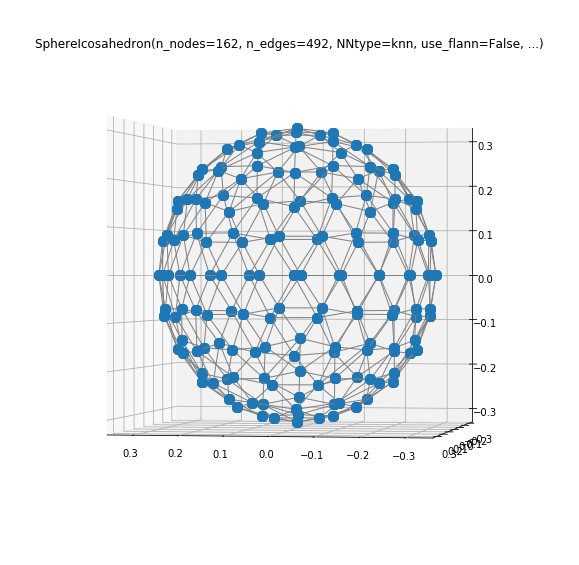

In [117]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

gIcosa = SphereIcosahedron(2, sampling='vertex')
gIcosa.plot(ax=ax)
ax.view_init(0, 100)

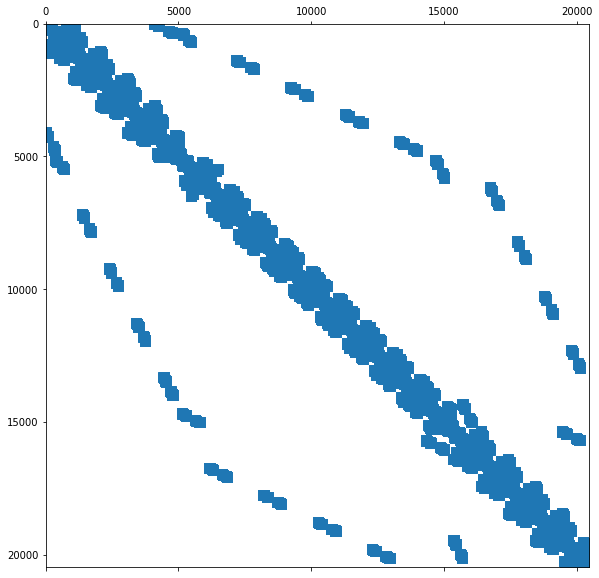

In [113]:
plt.spy(gIcosa.W)

2019-07-04 17:26:37,705:[WARNING](pygsp.graphs.graph._check_fourier_properties): The eigenvalues vector G.e is not available, we need to compute the Fourier basis. Explicitly call G.compute_fourier_basis() once beforehand to suppress the warning.
2019-07-04 17:26:37,706:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (20480 x 20480) is expensive. Consider decreasing n_eigenvectors or, if using the Fourier basis to filter, using a polynomial filter instead.


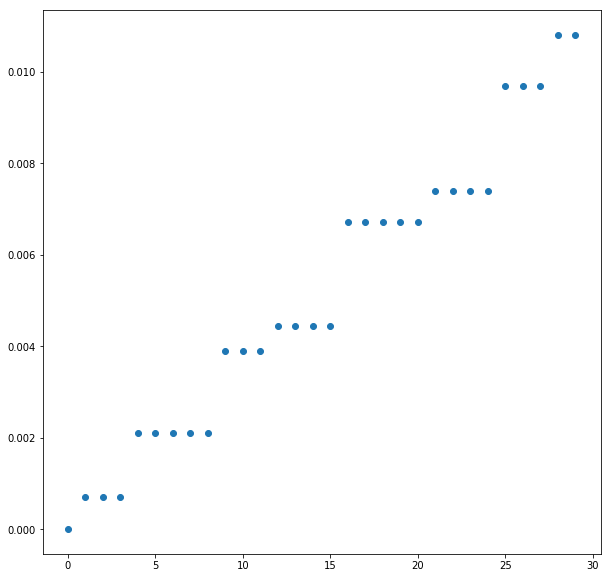

In [114]:
plt.plot(gIcosa.e[:30], 'o')

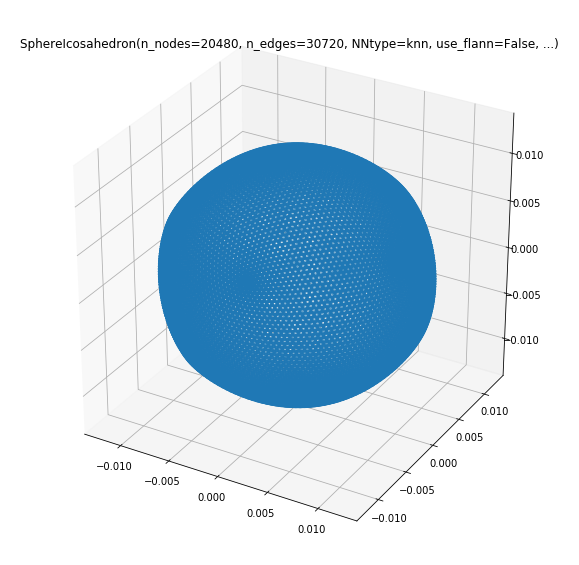

In [115]:
gIcosa.compute_laplacian("combinatorial")
#graphCyl.compute_fourier_basis(recompute=True)
gIcosa.set_coordinates(gIcosa.U[:,1:4])
gIcosa.plot(vertex_size=10)